In [1]:
import argparse
import os

import numpy as np

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from torchvision import models

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from itertools import product, permutations
import copy
import pickle
from PIL import Image

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [4]:
def filterLabelsByFrequency(artworks, frequency):
  for column in artworks.filter(regex='labels'):
    label_freq = artworks[column].apply(
        lambda s: [x for x in s]).explode().value_counts().sort_values(ascending=False)

    # Create a list of rare labels
    rare = list(label_freq[label_freq < frequency].index)

    artworks[column] = artworks[column].apply(
        lambda s: [x for x in s if x not in rare])
    artworks[column] = artworks[column].apply(
        lambda s: s if len(s) != 0 else np.nan)

  artworks.dropna(inplace=True)
  return artworks

In [5]:
with open("artworks", "rb") as file:
    artworks = pickle.load(file)

In [6]:
artworks = filterLabelsByFrequency(artworks, 100)

object_label_freq = artworks['object_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
style_label_freq = artworks['style_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
material_label_freq = artworks['material_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()

label_freq = pd.concat([object_label_freq, style_label_freq,
                       material_label_freq]).sort_values(ascending=False)

In [7]:
def count_labels(label_list):
    total_labels = []
    for labels in label_list:
      labels = list(filter(None, labels))
      total_labels.extend(labels)

    return len(list(set(total_labels))), list(set(total_labels))


def get_index_of_np(numpy, val):
  index_np = np.where(numpy == val)[0]

  if index_np.size != 1:
    print('a', index_np[0], index_np.size, val)
    return None
  else:
    return index_np[0]

In [8]:
def get_adjacency_matrix(artwork_labels_list, total_labels, N_LABEL):
  adjacency_matrix = np.zeros((N_LABEL, N_LABEL))

  for artwork_labels in artwork_labels_list:
    label_combinations = list(product(artwork_labels, repeat=2))

    for label_combination in label_combinations:
      pivot_index = get_index_of_np(total_labels, label_combination[0])
      target_index = get_index_of_np(total_labels, label_combination[1])
      if (pivot_index is None) or (target_index is None):
        return None
      else:
        adjacency_matrix[pivot_index][target_index] += 1

  for row_index, row in enumerate(adjacency_matrix):
    basis = row[row_index]
    for col_index, val in enumerate(row):
      row[col_index] = val/basis

  return adjacency_matrix

In [9]:
def convert_to_graph(artworks):
  label_classes = ['object_labels', 'style_labels', 'material_labels']
  artwork_labels_list = []
  labels_list_by_class = [set() for _ in range(3)]

  for index, label_class in enumerate(label_classes):
    labels_group = artworks[label_class]

    if index == 0:
      for labels in labels_group:
        artwork_labels_list.append(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(
            set(copy.deepcopy(labels)))
    else:
      for i, labels in enumerate(labels_group):
        artwork_labels_list[i].extend(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(
            set(copy.deepcopy(labels)))

  N_LABEL, total_labels = count_labels(artwork_labels_list)
  adjacency_matrix = get_adjacency_matrix(
      artwork_labels_list, np.array(total_labels), N_LABEL)

  class_one_hot_encoding_matrix = np.zeros((N_LABEL, 3))

  for i in range(N_LABEL):
    label = total_labels[i]
    for j in range(3):
      class_one_hot_encoding_matrix[i][j] = np.any(
          np.array(list(labels_list_by_class[j])) == label)

  embedding = nn.Embedding(N_LABEL, embedding_dim=5)
  input = torch.tensor(range(len(total_labels)))
  word_embedding_matrix = embedding(input).detach().cpu().numpy()

  feature_matrix = np.concatenate(
      (class_one_hot_encoding_matrix, word_embedding_matrix), axis=1)

  return adjacency_matrix, feature_matrix, N_LABEL, total_labels

In [10]:
adjacency_matrix, feature_matrix, N_LABEL, total_labels = convert_to_graph(
    artworks)

In [11]:
feature_matrix_tensor = torch.Tensor(
    feature_matrix).to(torch.float32)
adjacency_matrix_tensor = torch.Tensor(
    adjacency_matrix).to(torch.float32)
degree_matrix_tensor = torch.diag(torch.sum(adjacency_matrix_tensor, dim=1))
laplacian_matrix_tensor = degree_matrix_tensor - adjacency_matrix_tensor

In [12]:
root_path = './database_all'

In [13]:
artworks['labels'] = artworks['object_labels'] + \
    artworks['style_labels'] + artworks['material_labels']

dataset_size = len(artworks)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.2)
test_size = int(validation_size * 0.5)

X_train, X_val, y_train, y_val = train_test_split(
    artworks['File'], artworks['labels'], test_size=0.2, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=23)

X_train = [os.path.join(root_path, str(f)) for f in X_train]
X_val = [os.path.join(root_path, str(f)) for f in X_val]
X_test = [os.path.join(root_path, str(f)) for f in X_test]

label_list = pd.DataFrame({'labels': [total_labels]})
mlb = MultiLabelBinarizer(classes=total_labels)
mlb.fit(label_list['labels'])

y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)
y_train_bin = mlb.transform(y_train).astype(np.float64)
y_val_bin = mlb.transform(y_val).astype(np.float64)
y_test_bin = mlb.transform(y_test).astype(np.float64)

In [14]:
class ArtworksDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = Image.open(self.X[index]).convert('RGB')
        label = torch.tensor(self.y[index], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label

In [15]:
def get_dataloader(X, y, batch_size, mode='train', shuffle=True, random_seed=42):
    if shuffle:
        torch.manual_seed(random_seed)

    if mode == 'train':
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    dataset = ArtworksDataset(X, y, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=shuffle, generator=torch.Generator(device=device))
    total_batch = dataset.__len__() // batch_size
    return dataloader, total_batch

In [16]:
class AttentionModule(nn.Module):
  def __init__(self, in_dim, out_dim, head_num=2):
    super(AttentionModule, self).__init__()

    self.head_num = head_num
    self.attention_dim = out_dim // head_num

    self.linears = nn.ModuleList()
    self.correlations = nn.ParameterList()
    for i in range(self.head_num):
      self.linears.append(nn.Linear(in_dim, self.attention_dim))
      correlation = torch.FloatTensor(
          self.attention_dim, self.attention_dim)
      nn.init.xavier_uniform_(correlation)
      self.correlations.append(nn.Parameter(correlation))

    self.tanh = nn.Tanh()
    self.set_out_dim = nn.Linear(head_num * self.attention_dim, out_dim)

  def forward(self, x, adj):
    heads = list()
    for i in range(self.head_num):
      x_i = self.linears[i](x)
      alpha = self.attention_matrix(x_i, self.correlations[i], adj)
      x_head = torch.matmul(alpha, x_i)
      heads.append(x_head)
    out = torch.cat(heads, dim=2)
    out = self.set_out_dim(out)
    return out

  def attention_matrix(self, x_i, correlation, adj):
    x = torch.matmul(x_i, correlation)
    alpha = torch.matmul(x, torch.transpose(x_i, 1, 2))
    alpha = torch.mul(alpha, adj)
    alpha = self.tanh(alpha)
    return alpha

In [17]:
class GCNLayer(nn.Module):
	def __init__(self, in_dim, out_dim, act=None, atn=False, head_num=2, drop_rate=0):
		super(GCNLayer, self).__init__()

		self.linear = nn.Linear(in_dim, out_dim)
		nn.init.xavier_uniform_(self.linear.weight)
		self.activation = act
		self.use_attention = atn
		self.attention = AttentionModule(out_dim, out_dim, head_num)
		self.drop_rate = drop_rate
		self.dropout = nn.Dropout(self.drop_rate)

	def forward(self, x, adj):
		out = self.linear(x)
		if self.use_attention:
			out = self.attention(out, adj)
		out = torch.matmul(adj, out)
		if self.activation != None:
			out = self.activation(out)
		if self.drop_rate > 0:
			out = self.dropout(out)
		return out, adj

In [18]:
class GatedSkipConnection(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(GatedSkipConnection, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    self.linear = nn.Linear(in_dim, out_dim, bias=False)
    self.linear_coef_in = nn.Linear(out_dim, out_dim)
    self.linear_coef_out = nn.Linear(out_dim, out_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, in_x, out_x):
    if (self.in_dim != self.out_dim):
        in_x = self.linear(in_x)
    z = self.gate_coefficient(in_x, out_x)
    out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
    return out

  def gate_coefficient(self, in_x, out_x):
    x1 = self.linear_coef_in(in_x)
    x2 = self.linear_coef_out(out_x)
    return self.sigmoid(x1+x2)

In [19]:
class GCNBlock(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, sc='gsc', act=None, atn=True, head_num=2, drop_rate=0):
    super(GCNBlock, self).__init__()

    self.layers = nn.ModuleList()
    for i in range(n_layer):
        self.layers.append(GCNLayer(in_dim if i == 0 else hidden_dim,
                                    out_dim if i == n_layer-1 else hidden_dim,
                                    act,
                                    False if i == n_layer-1 else atn,
                                    1 if i == n_layer-1 else head_num,
                                    drop_rate))
    if sc == 'gsc':
        self.sc = GatedSkipConnection(in_dim, out_dim)
    elif sc == 'no':
        self.sc = None
    else:
        assert False, "Wrong sc type."

  def forward(self, x, adj):
    residual = x
    out = None
    for i, layer in enumerate(self.layers):
        out, adj = layer((x if i == 0 else out), adj)
    if self.sc != None:
        out = self.sc(residual, out)
    return out, adj

In [20]:
class InceptionModule(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, sc='gsc', act=None, atn=True, head_num=2, drop_rate=0):
    super(InceptionModule, self).__init__()
    self.GCNBlocks = nn.ModuleList()
    for i in range(n_layer):
      self.GCNBlocks.append(GCNBlock(i + 1,
                                     in_dim,
                                     hidden_dim,
                                     out_dim,
                                     sc,
                                     act,
                                     atn,
                                     head_num,
                                     drop_rate))

  def forward(self, x, adj):
    outs = []
    for i, block in enumerate(self.GCNBlocks):
      out, _ = block(x, adj)
      outs.append(out)

    feature_concatenate = torch.cat(outs, 2)
    return feature_concatenate, adj

In [21]:
class ReadOut(nn.Module):
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        out = torch.squeeze(out)
        return out

In [22]:
class GCNNet(nn.Module):
  def __init__(self, args, adj):
    super(GCNNet, self).__init__()

    self.InceptionModule = InceptionModule(args.n_layer,
                                           args.in_dim,
                                           args.hidden_dim,
                                           args.out_dim,
                                           args.sc,
                                           args.act,
                                           args.atn,
                                           args.head_num,
                                           args.drop_rate)
    self.Readout = ReadOut(args.out_dim * args.n_layer,
                           1, None)
    self.adj = adj

  def forward(self, x):
    out, _ = self.InceptionModule(x, self.adj)
    out = self.Readout(out)

    return out

In [23]:
# Define the model architecture
class Resnet50(nn.Module):
    def __init__(self, n_label):
        super(Resnet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, n_label)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

In [24]:
class CNNGCN_2(nn.Module):
	def __init__(self, num_classes, adj, args):
		super(CNNGCN_2, self).__init__()
		self.cnn = Resnet50(num_classes)
		self.gcnnet = GCNNet(args, adj)

	def forward(self, x):
		cnn_out = self.cnn(x)
		cnn_out_2 = torch.transpose(torch.unsqueeze(cnn_out, 1), 1, 2)
		gcn_out = self.gcnnet(cnn_out_2)
		return gcn_out

In [25]:
def multi_label_metrics(y_true, y_pred):
    """
    다중 레이블 분류 문제에서 Precision, recall, F1 score 계산 함수
    
    Args:
        y_true (torch.Tensor): 정답 레이블. shape: (batch_size, num_classes)
        y_pred (torch.Tensor): 모델 예측 레이블. shape: (batch_size, num_classes)
        
    Returns:
        precision (float): Precision 값
        recall (float): Recall 값
        f1_score (float): F1 Score 값
    """
    true_positives = torch.sum((y_true == 1) & (y_pred == 1), dim=0)
    false_positives = torch.sum((y_true == 0) & (y_pred == 1), dim=0)
    false_negatives = torch.sum((y_true == 1) & (y_pred == 0), dim=0)

    precision = torch.mean(
        true_positives / (true_positives + false_positives + 1e-8))
    recall = torch.mean(
        true_positives / (true_positives + false_negatives + 1e-8))
    f1_score = 2 * ((precision * recall) / (precision + recall + 1e-8))

    return precision.item(), recall.item(), f1_score.item()

In [29]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.n_layer = 3
args.in_dim = 1
args.hidden_dim = 5
args.out_dim = 1
args.sc = 'gsc'
args.act = nn.ELU()
args.atn = False
args.head_num = 2
args.drop_rate = 0

model_path = './models/'
model_cnngcn = CNNGCN_2(N_LABEL, laplacian_matrix_tensor, args)
model_cnngcn.load_state_dict(torch.load(
    './models/cnngnn-epoch30_3_1_5_1_gsc_elu_false_2_0.pt'))


<All keys matched successfully>

In [30]:
test_loader, test_total_batch = get_dataloader(
    X_test, y_test_bin, 16, 'test')

criterion = nn.MultiLabelSoftMarginLoss()
model_cnngcn.eval()
test_running_loss = 0.0
test_total_predictions = []
test_total_labels = []

for test_inputs, test_labels in test_loader:
    test_inputs = test_inputs.to(device)
    test_labels = test_labels.to(device)

    # 모델에 입력값 전달
    test_outputs = model_cnngcn(test_inputs)

    # 손실 계산
    test_loss = criterion(test_outputs, test_labels)

    # 예측값 계산
    test_prediction = torch.sigmoid(test_outputs) >= 0.5

    # 정확도 계산
    test_running_loss += test_loss.item() * test_inputs.size(0)
    test_total_predictions += test_prediction.tolist()
    test_total_labels += test_labels.tolist()

test_epoch_loss = test_running_loss / len(test_loader.dataset)
test_precision, test_recall, test_f1_score = multi_label_metrics(
    torch.tensor(test_total_labels), torch.tensor(test_total_predictions))
print(test_epoch_loss, test_precision, test_recall, test_f1_score)


1.1210385767618816 0.014507339335978031 0.24750685691833496 0.02740817703306675


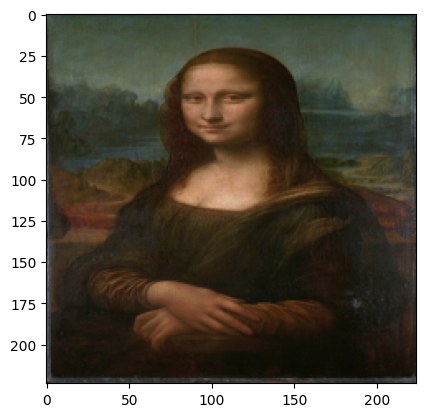

In [31]:
from PIL import Image

test2 = Image.open(
    './test_data/nude-seated-on-the-grass-1950(1).jpg')
test3 = Image.open(
    './test_data/warhol_scream_large.jpg')

test2_resize = test2.resize((224, 224))
test3_resize = test3.resize((224, 224))
plt.imshow(test2_resize, cmap='gray')
plt.imshow(test3_resize, cmap='gray')


In [32]:
model_cnngcn.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def prediction(img):
	img_tensor = transform(img)
	img_tensor = img_tensor.unsqueeze(0).to(device)

	output = model_cnngcn(img_tensor)
	prediction = torch.sigmoid(output) >= 0.5

	result = []
	for index, value in enumerate(prediction):
			if value == 1:
					result.append(total_labels[index])

	print(result)

	prediction(test2_resize)
	prediction(test3_resize)


['photography', 'regionalism', 'shin-hanga', 'caricature', 'flower painting', 'intimism', 'tronie', 'nude painting (nu)', 'conceptual art', 'silkscreen', 'graffiti', 'street photography', 'abstract expressionism', 'mixed media', 'capriccio', 'pen', 'sketch and study', 'neo-impressionism', 'kitsch', 'graphite', 'pointillism', 'pastel', 'magic realism', 'analytical cubism', 'american realism', 'dada', 'new kingdom', 'neo-geo', 'linen', 'photorealism', 'cityscape', 'genre painting ', 'realism', 'figurative expressionism', 'impressionism', 'installation', 'interior', 'ink', 'constructivism', 'still life', 'post-impressionism', 'social realism', 'ink and wash painting', 'metaphysical art', 'bronze', 'history painting', 'print', 'hyper-realism', 'miniature', 'biedermeier', 'calligraphy', 'veduta', 'wildlife painting', 'purism', 'drawing', 'art deco', 'environmental (land) art', 'light and space', 'genre painting', 'watercolor', 'sculpture', 'orientalism', 'feminist art', 'cloisonnism', 'synt